# **Phase 2 - Milestone 2**

**Ediashta Revindra Amirussalam**
<br>FTDS-020-RMT

## Objective

Emosi adalah keadaan psikologis kompleks yang melibatkan perasaan, pikiran, dan perubahan fisiologis. Emosi dapat mencakup perasaan positif, negatif, atau netral dan memainkan peran penting dalam interaksi sosial, pengambilan keputusan, dan kesejahteraan psikologis seseorang. Ekspresi wajah kadang-kadang dapat memberikan petunjuk tentang emosi atau reaksi seseorang, tetapi mereka bukanlah indikator yang dapat diandalkan untuk mengetahui apakah seseorang berbicara jujur atau tidak. Ide bahwa ekspresi wajah tertentu terkait dengan kebohongan didasarkan pada "teori mikroekspresi" yang dipopulerkan oleh psikolog Paul Ekman. Menurut teori ini, beberapa ekspresi wajah singkat dapat mengungkapkan emosi sebenarnya seseorang, meskipun mereka berusaha menyembunyikannya.

Project kali ini dibuat untuk menghasilkan sebuah Deep Neural Network yang dapat mengetahui emosi seseorang dengan menggunakan sebuah gambar

## 00 - Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import glob
import random
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [2]:
tf.__version__

'2.10.1'

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 01 - Data Loading

Dataset yang digunakan pada kali ini merupakan dataset FER2013 yang berisikan lebih dari 30.000 data yang dibagi kedalam 7 emosi dasar manusia antara lain:
* Angry
* Disgust
* Fear
* Happy
* Neutral
* Sad
* Suprised

Dataset dapat diakses melalui link berikut:
[FER2013 - Kaggle](https://www.kaggle.com/code/odins0n/emotion-detection)

### Google Colab

In [4]:
# from google.colab import drive
# drive.flush_and_unmount()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !rm ~/.kaggle

In [7]:
# !mkdir ~/.kaggle

# !cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

In [8]:
# !ls ~/.kaggle

In [9]:
# !kaggle datasets download -d ananthu017/emotion-detection-fer

In [10]:
# !unzip -q /content/emotion-detection-fer.zip -d images

In [11]:
# main_path = ('/content/images')
# os.listdir(main_path)

### Local

In [12]:
main_path = ('./datasets')
os.listdir(main_path)

['test', 'train']

### Extraction

In [13]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
os.listdir(train_dir)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Terdapat 2 folder pada dataset yaitu train dan test, yang masing-masing berisikan 7 folder berdasarkan emosi

In [14]:
def check_dir(dir=None, labels=None):
  i=0
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Data', label, ' :', num_data)
    i+= num_data
  print('Total Data :', i)



In [15]:
print('train set: \n' + '='*50)
check_dir(train_dir,os.listdir(train_dir))
print('\ntest set: \n' + '='*50)
check_dir(test_dir,os.listdir(test_dir))

train set: 
Data angry  : 3995
Data disgusted  : 436
Data fearful  : 4097
Data happy  : 7215
Data neutral  : 4965
Data sad  : 4830
Data surprised  : 3171
Total Data : 28709

test set: 
Data angry  : 958
Data disgusted  : 111
Data fearful  : 1024
Data happy  : 1774
Data neutral  : 1233
Data sad  : 1247
Data surprised  : 831
Total Data : 7178


Total data pada dataset ini yaitu 28709 pada train-set dan 7178 pada test-set

## 02 - EDA & Preprocessing

### Display Sample Image

(48, 48)


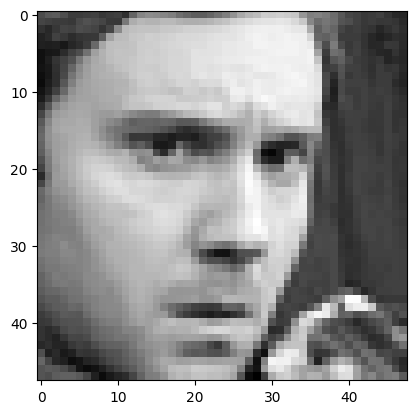

In [16]:
img = plt.imread(f'{train_dir}/angry/im0.png')
print(img.shape)
plt.imshow(img, cmap="gray")

Pada dataset ini, dimensi gambar adalah **48x48** pixel dengan color profile **grayscale**

#### Image Distribution

In [17]:
class_labels  = [class_name.capitalize() for class_name in os.listdir(train_dir)]
img_height = 48
img_width = 48
batch_size = 64

In [18]:
img_count = pd.DataFrame(columns=['label', 'count'])

for i in os.listdir(train_dir):
    value = len([fn for fn in os.listdir(f'{train_dir}/{i}/') if fn.endswith('.png')])
    img_count.loc[len(img_count.index)] = [i, value]

img_count.sort_values(by="count", ascending=False, inplace=True)

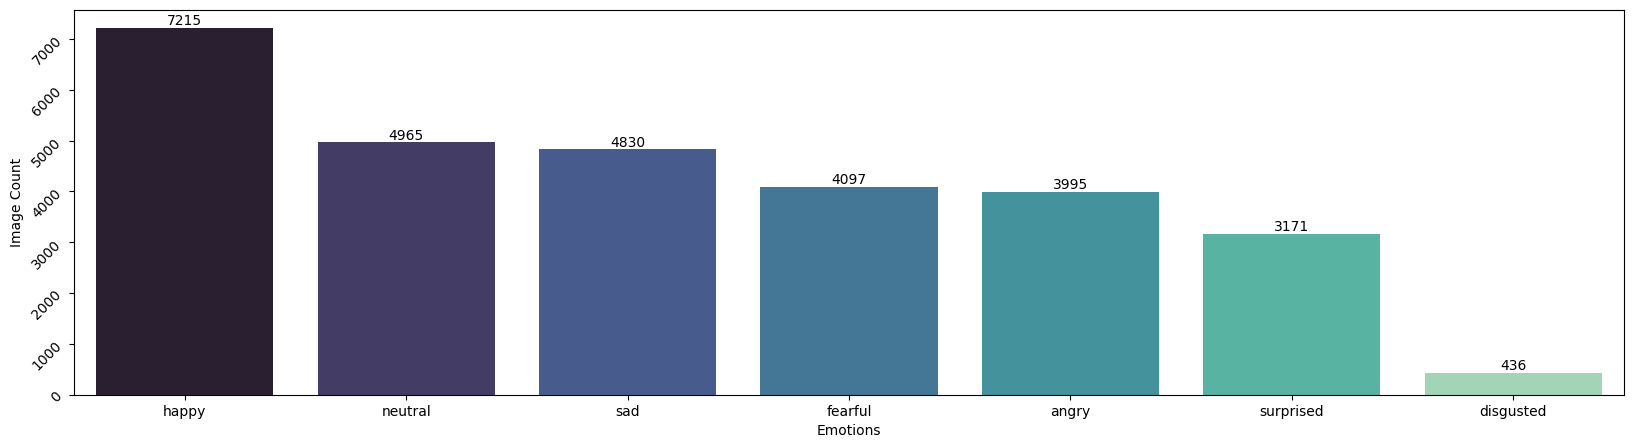

In [19]:
plt.figure(figsize=(20,5))
fig = sns.barplot(x="label",
                  y="count",
                  data=img_count,
                  palette="mako")
fig.set(xlabel="Emotions", ylabel="Image Count")

for i in fig.containers:
    fig.bar_label(i,)

plt.yticks(rotation=45)
plt.show()

Pada dataset ini, jumlah data antar kelas dapat dikatakan tidak berimbang, terlihat jauh lebih banyak data pada emosi bahagia dan pada emosi jijik jumlah data sangat sedikit, sedangkan untuk emosi lainnya cukup merata. Hal ini kemungkinan dapat memengaruhi kemampuan mesin dalam mempelajari data dengan jumlah sedikit dan cendereung memprediksi emosi kedalam kategori bahagia

### Individual Emotion Analysis

Kita dapat menganalisa tiap jenis emosi pada dataset untuk mengetahui karakteristik dari masing-masing emosi, kita dapat mengidentifikasi karakteristik melalui fitur wajah seperti alis, mata, hidung, dan mulut

In [20]:
def visualize_img(title, train_dir):
    random.seed(5)
    images = random.sample([fn for fn in os.listdir(f'{train_dir}/{title}') if fn.endswith('.png')],7)
    fig, axes = plt.subplots(1,7, figsize=(21,5))

    for i, x in enumerate(images):
        img = plt.imread(f'{train_dir}/{title}/{x}')
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(title.capitalize())
        axes[i].axis('off')

    fig.tight_layout()

#### Angry

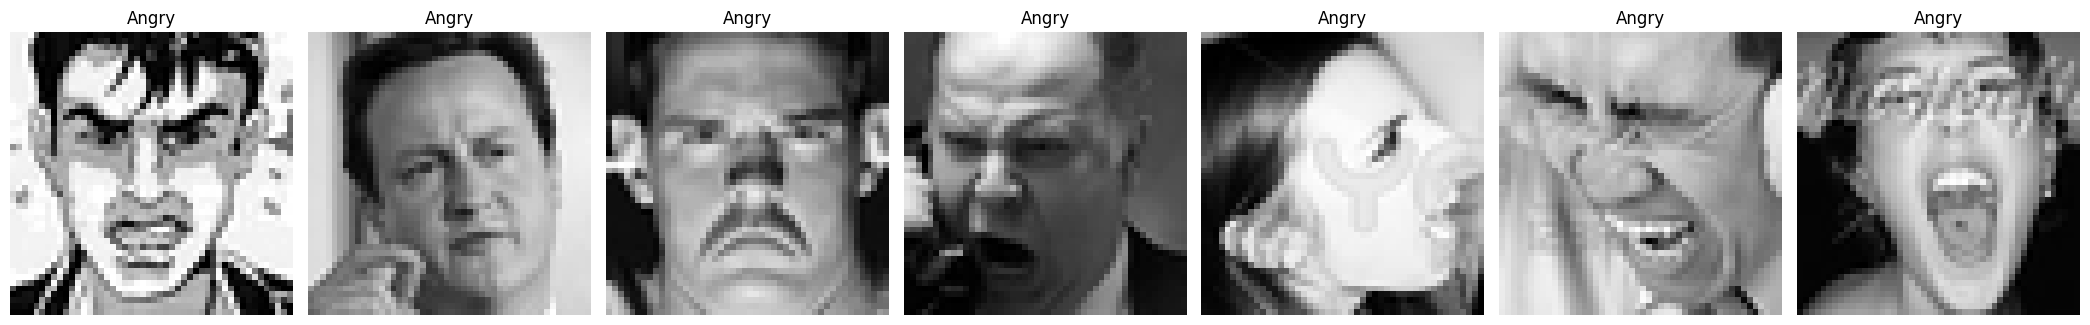

In [21]:
visualize_img('angry', train_dir)

Emosi ini biasanya ditandai dengan perasaan amarah, frustrasi, dan ketidakpuasan terhadap sesuatu yang dianggap mengancam atau menyakitkan. 

Ciri Fisik:
* Bagian luar alis terangkat
* Mata biasanya menyipit dan tajam
* Bagia mulut menegang

#### Disgusted

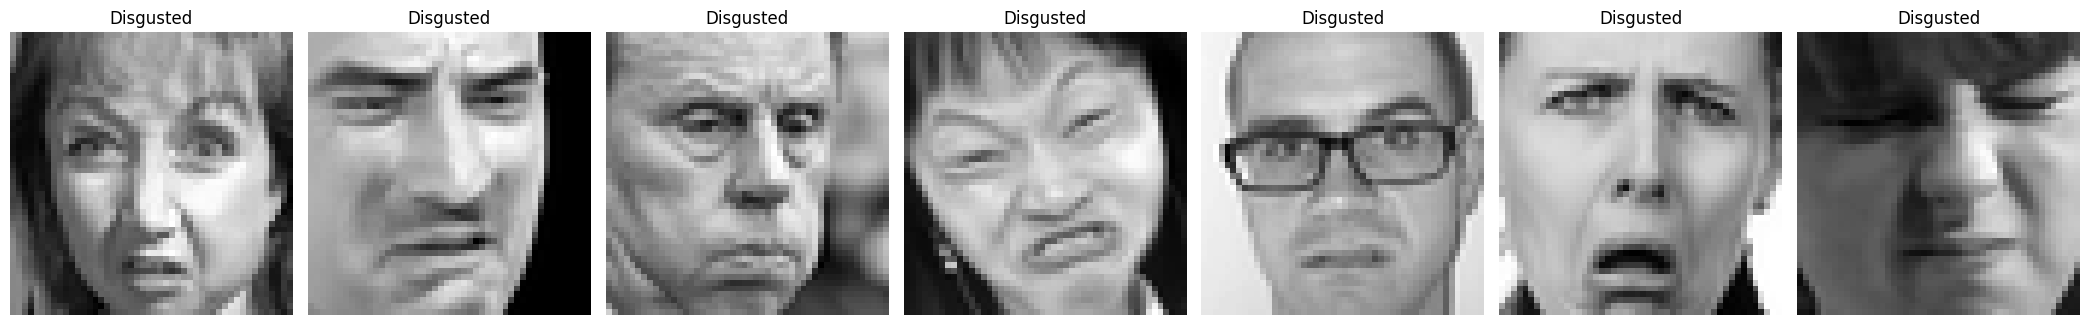

In [22]:
visualize_img('disgusted', train_dir)

Emosi ini berkaitan dengan perasaan takut atau merasa terganggu oleh sesuatu yang tidak disukai atau dianggap menjijikkan.

Ciri Fisik:
* Bagian alis terangkat
* Kelopak mata bagian bahwa terangkat
* Hidung mengkerut
* Biasanya bagian mulut terlihat sedikit menegang dan sedikit terangkat

#### Fearful

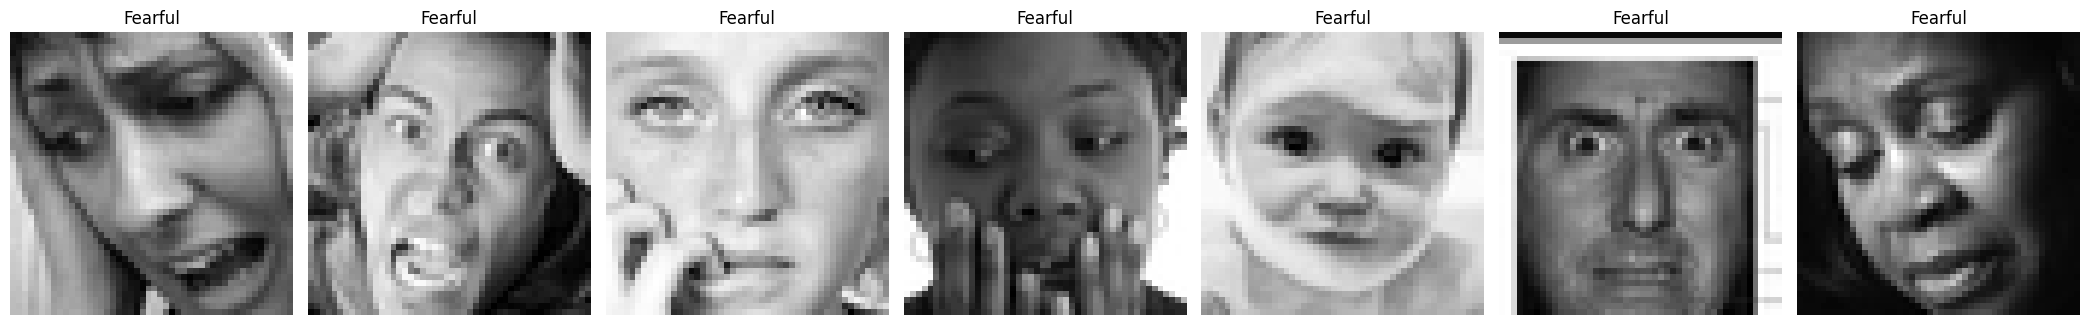

In [23]:
visualize_img('fearful', train_dir)

 Emosi ini melibatkan perasaan ketakutan atau cemas karena ada ancaman atau bahaya.
 
 Ciri Fisik:
 * Mata Melebar
 * Alis bagian luar sedikit turun
 * Mulut biasanya sedikit menurun
 * Pada emosi ini biasanya tangan digunakan untuk menutup bagian wajah

#### Happy

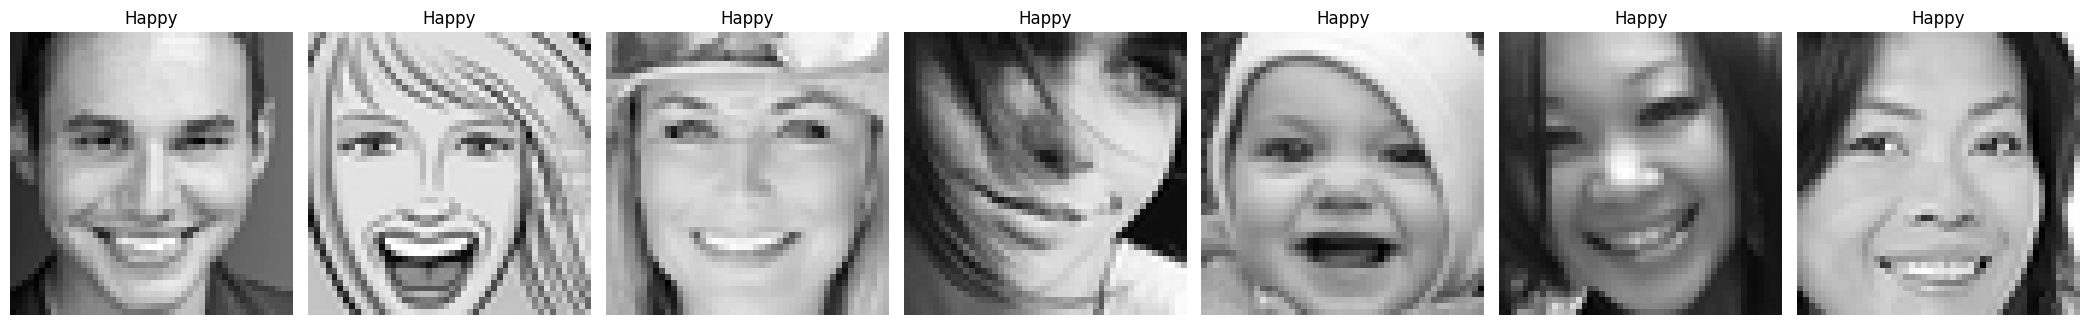

In [24]:
visualize_img('happy', train_dir)

Emosi ini biasanya ditandai dengan perasaan senang, gembira, dan puas. Ekspresi wajah yang bahagia mencakup senyuman, mata yang berbinar, serta cenderung bersifat terbuka dan ramah.

Ciri Fisik:
* Mata telihat berbinar
* Mulut tersenyum

#### Neutral

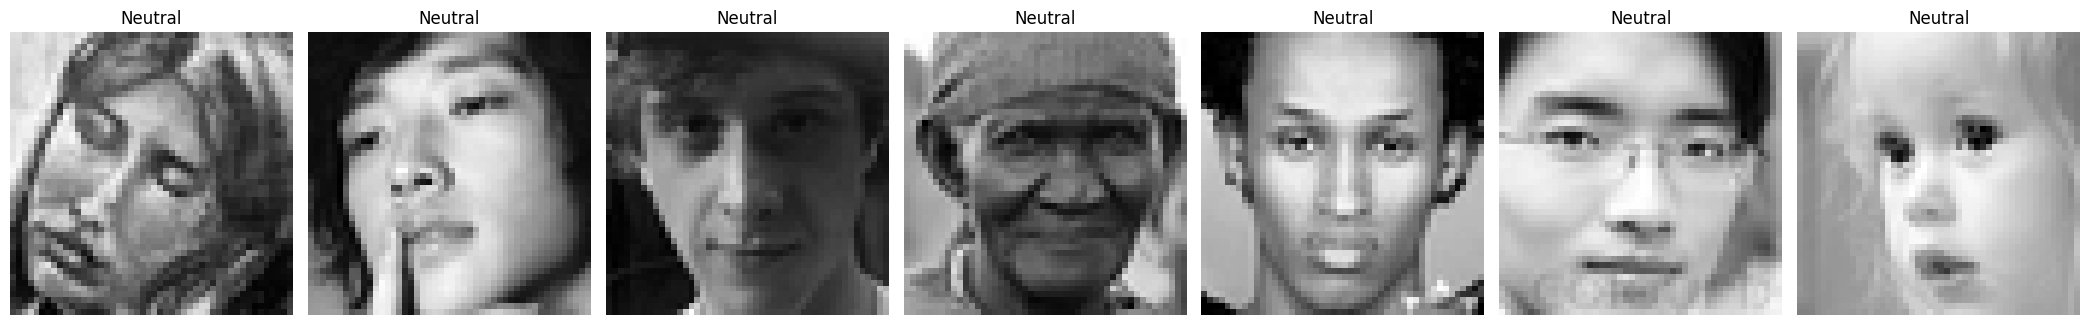

In [25]:
visualize_img('neutral', train_dir)

Emosi netral menunjukkan ketiadaan emosi yang kentara atau ekspresi wajah yang tidak menunjukkan perasaan intens.

Ciri Fisik pada ekspresi ini adalah tiap fitur wajah terlihat tidak menonjol

#### Sad

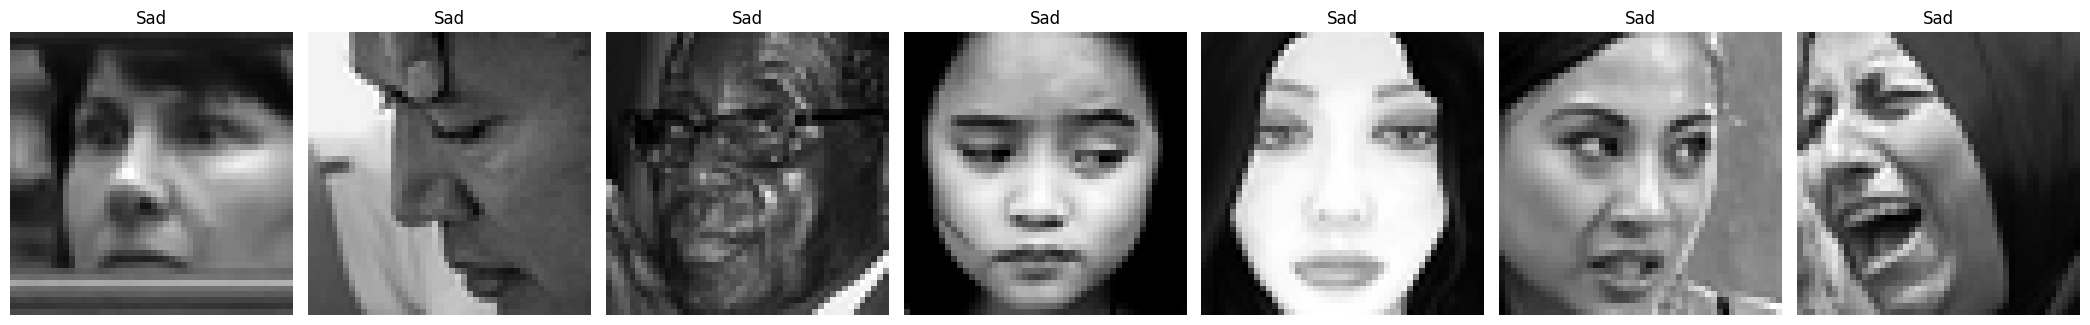

In [26]:
visualize_img('sad', train_dir)

Emosi ini melibatkan perasaan kesedihan, kekecewaan, dan kehilangan

Ciri Fisik:
* Alis biasanya terlihat mengkerut
* Mata menjadi lesu
* Bagian sudut mulut sedikit menurun

#### Surprised

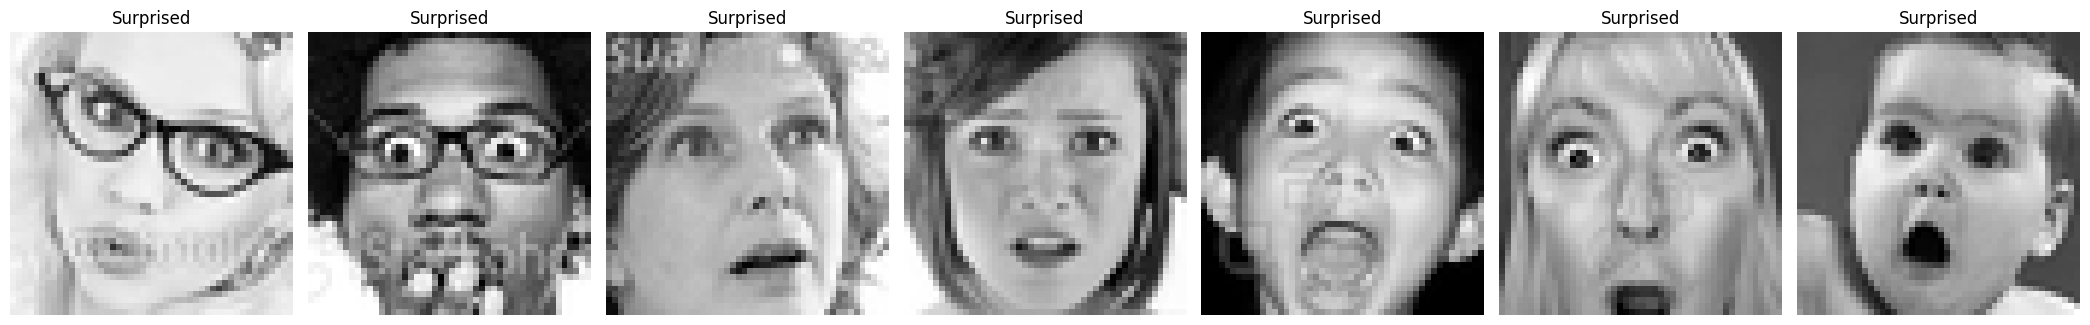

In [27]:
visualize_img('surprised', train_dir)

Emosi ini muncul ketika seseorang mendapat peristiwa atau informasi yang tak terduga.

Ciri Fisik:
* Alis naik secara keseluruhan
* Mata melebar
* Biasanya mulut terbuka

### Image Vector Mean

Kemudian kita dapat melihat karakteristik dari tiap kelas pada dataset dengan menggunakan mean dari tiap-tiap gambar

In [28]:
def img2np(path, list_of_filename, size = (48, 48)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [29]:
def find_mean_img(full_mat, title, axes, loc, size = (48, 48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)

    # mean_img = sharpened

    axes[loc].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axes[loc].set_title(f'Average {title}')
    return mean_img

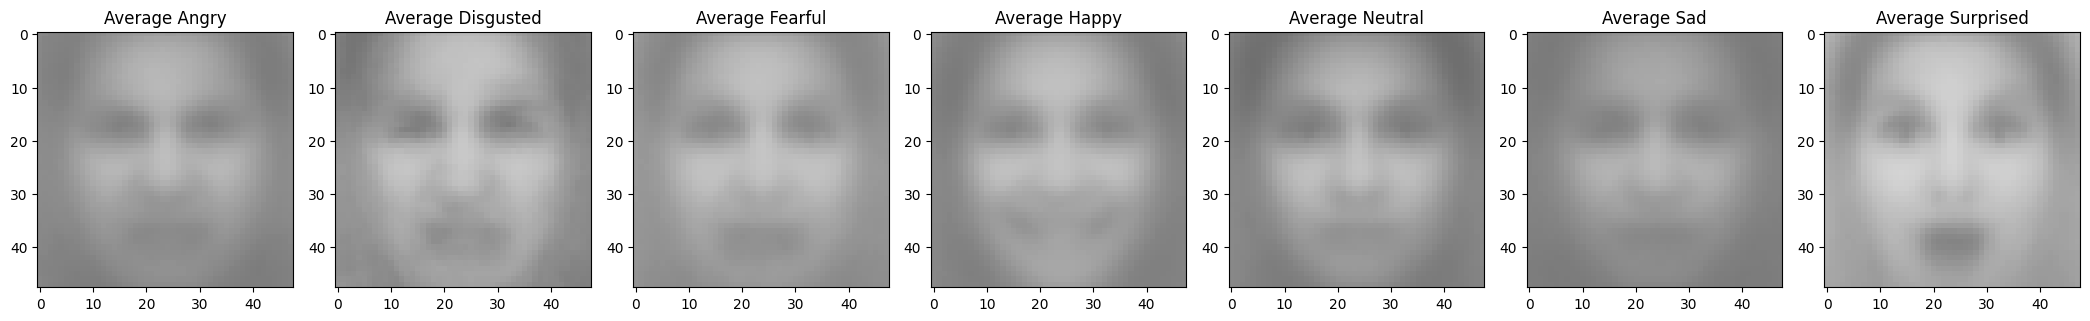

In [30]:
fig, axes= plt.subplots(1,7, figsize=(21,3))
count = 0

for i in os.listdir(train_dir):
    images = [fn for fn in os.listdir(f'{train_dir}/{i}') if fn.endswith('.png')]
    vector = img2np(f'{train_dir}/{i}/',images)
    find_mean_img(vector, i.capitalize(),axes, count)

    count+=1

plt.tight_layout()
plt.show()

Dari perhitungan mean ini didapatkan informasi sebagai berikut:
* Ekspresi yang paling menonjol adalah Happy dan Surprised, dapat mudah diidentifikasi dari karakteristik mulut
* Untuk ekspresi Sad, Fearful dan Netral, agak sedikit sulit untuk dibedakan
* Sedangkan ekspresi Angry dan Disgusted terlihat mirip dari karakteristik alis dan mulutnya

### Preprocessing and Augmentation

In [57]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   rotation_range=15,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun)

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                   )

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 03 - Base Model

### Model Definition

In [66]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [67]:
# Define the input shape and number of classes for your dataset
input_shape = (img_height, img_width, 3)
num_classes = 7

In [68]:
model = Sequential()

model.add(
       Conv2D(
       filters=64,
       kernel_size=(5,5),
       input_shape=input_shape,
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_1'
       )
)
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
       Conv2D(
       filters=64,
       kernel_size=(5,5),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_2'
       )
)
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(
       Conv2D(
       filters=128,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_3'
       )
)
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
       Conv2D(
       filters=128,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_4'
       )
)
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(
       Conv2D(
       filters=256,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_5'
       )
)
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
       Conv2D(
       filters=256,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_6'
       )
)
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Flatten(name='flatten'))
       
model.add(
       Dense(
       128,
       activation='elu',
       kernel_initializer='he_normal',
       name='dense_1'
       )
)
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.6, name='dropout_4'))

model.add(
       Dense(
       num_classes,
       activation='softmax',
       name='out_layer'
       )
)

In [69]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0

### Model Training

In [70]:
history = model.fit(x = train_ds,
                    epochs = 50,
                    validation_data = test_ds)

Epoch 1/50
449/449 [==============================] - 31s 64ms/step - loss: 2.1462 - accuracy: 0.2390 - val_loss: 1.7671 - val_accuracy: 0.2707
Epoch 2/50
449/449 [==============================] - 28s 62ms/step - loss: 1.6610 - accuracy: 0.3539 - val_loss: 1.4798 - val_accuracy: 0.4270
Epoch 3/50
449/449 [==============================] - 28s 61ms/step - loss: 1.4853 - accuracy: 0.4272 - val_loss: 1.3738 - val_accuracy: 0.4765
Epoch 4/50
449/449 [==============================] - 28s 63ms/step - loss: 1.3853 - accuracy: 0.4692 - val_loss: 1.2865 - val_accuracy: 0.4999
Epoch 5/50
449/449 [==============================] - 28s 61ms/step - loss: 1.3218 - accuracy: 0.4969 - val_loss: 1.2144 - val_accuracy: 0.5315
Epoch 6/50
449/449 [==============================] - 28s 62ms/step - loss: 1.2681 - accuracy: 0.5191 - val_loss: 1.2923 - val_accuracy: 0.5056
Epoch 7/50
449/449 [==============================] - 28s 63ms/step - loss: 1.2278 - accuracy: 0.5330 - val_loss: 1.1661 - val_accuracy:

In [75]:
history_df = pd.DataFrame(history.history)

history_df.tail()

,loss,accuracy,val_loss,val_accuracy
45,0.865594,0.681250,0.972912,0.651574
46,0.855262,0.685255,0.963941,0.645584
47,0.857587,0.679090,0.912336,0.673586
48,0.851180,0.686823,0.928975,0.660072
49,0.850136,0.684977,0.962029,0.663137


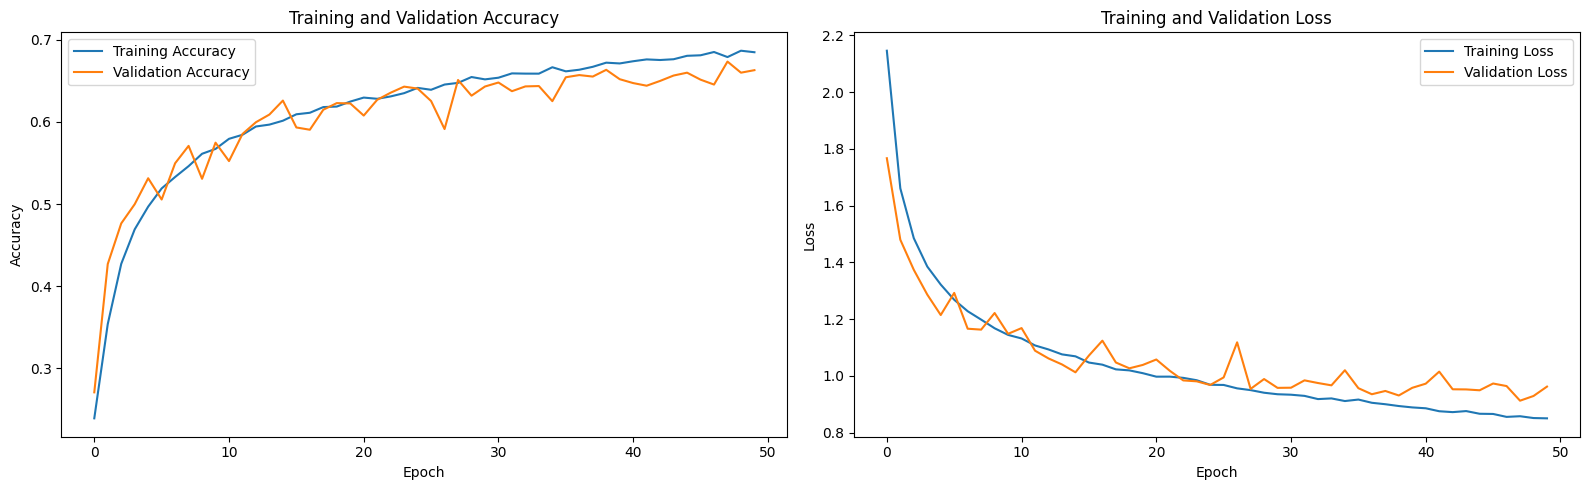

In [76]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

In [77]:
model.trainable = False
# model.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_default.h5") #google colab
model.save('./model/model_default.h5') #local

### Model Evaluation

In [78]:
model.evaluate(test_ds)
preds = model.predict(test_ds)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_ds.labels)

113/113 [==============================] - 3s 23ms/step


In [79]:
cm_array = confusion_matrix(y_true=y_test, y_pred=y_preds)

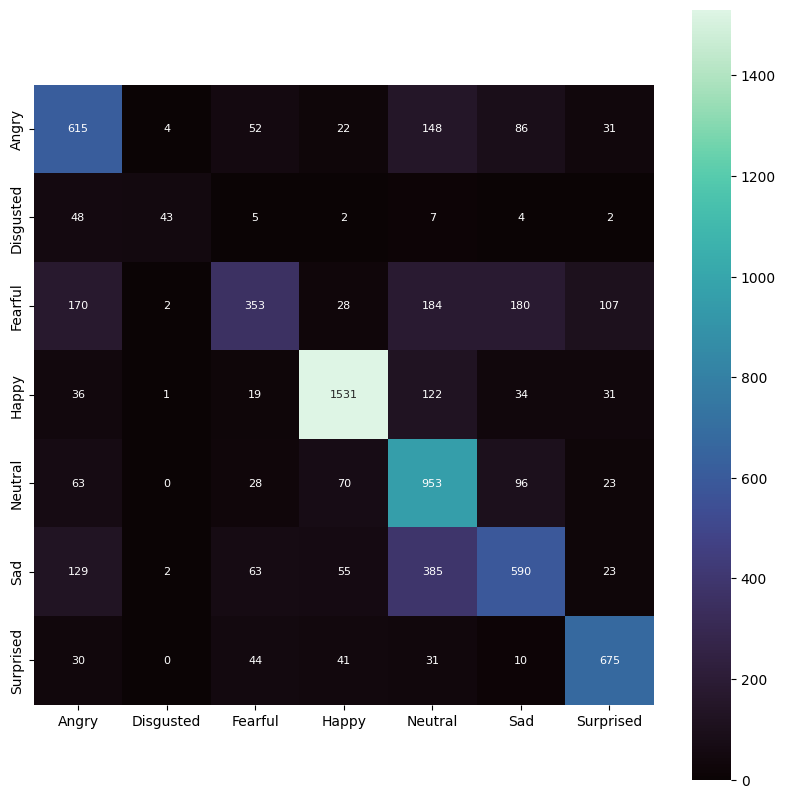

In [80]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)


In [64]:
print(classification_report(y_true=y_test, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.40      0.41      0.40       958
           1       0.39      0.20      0.26       111
           2       0.36      0.27      0.31      1024
           3       0.75      0.61      0.67      1774
           4       0.40      0.47      0.43      1233
           5       0.36      0.46      0.40      1247
           6       0.60      0.65      0.62       831

    accuracy                           0.48      7178
   macro avg       0.47      0.44      0.44      7178
weighted avg       0.50      0.48      0.48      7178



## 04 - Fine Tuned Model

### Model Definition

In [129]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [134]:
def build_model():
        model = Sequential()
        
        model.add(
        Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
        )
        )
        model.add(BatchNormalization(name='batchnorm_1'))
        model.add(
        Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
        )
        )
        model.add(BatchNormalization(name='batchnorm_2'))

        model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_1'))
        model.add(Dropout(0.4, name='dropout_1'))

        model.add(
        Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
        )
        )
        model.add(BatchNormalization(name='batchnorm_3'))
        model.add(
        Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
        )
        )
        model.add(BatchNormalization(name='batchnorm_4'))

        model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_2'))
        model.add(Dropout(0.4, name='dropout_2'))

        model.add(
        Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
        )
        )
        model.add(BatchNormalization(name='batchnorm_5'))
        model.add(
        Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
        )
        )
        model.add(BatchNormalization(name='batchnorm_6'))

        model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_3'))
        model.add(Dropout(0.5, name='dropout_3'))

        model.add(Flatten(name='flatten'))
        
        model.add(
        Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
        )
        )
        model.add(BatchNormalization(name='batchnorm_7'))

        model.add(Dropout(0.6, name='dropout_4'))

        model.add(
        Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
        )
        )
        
        model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy'])
        
        return model

In [135]:
model_ft = build_model() 

model_ft.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)       

### Model Training

In [136]:
modelCheckpointCallback = ModelCheckpoint(
    # filepath='/content/drive/MyDrive/FTDS/Emotion Classification', #google colab
    filepath= './deployment/model/',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
)

earlyStoppingCallback = EarlyStopping(monitor='val_accuracy',
                                      patience=10,
                                      verbose= 1 ,
                                      restore_best_weights=True
                                      )

reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0)

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 80:
        lr *= 0.5e-3
    elif epoch > 60:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    return lr

In [137]:
history_ft = model_ft.fit(x = train_ds,
                    epochs = 100 ,
                    validation_data = test_ds , 
                    callbacks= [earlyStoppingCallback,
                                modelCheckpointCallback,
                                reduce_lr])

Epoch 1/100
449/449 [==============================] - 31s 67ms/step - loss: 2.1017 - accuracy: 0.2479 - val_loss: 1.8503 - val_accuracy: 0.2448 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 31s 68ms/step - loss: 1.6359 - accuracy: 0.3647 - val_loss: 1.5081 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 31s 69ms/step - loss: 1.4814 - accuracy: 0.4298 - val_loss: 1.3624 - val_accuracy: 0.4687 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 31s 69ms/step - loss: 1.3861 - accuracy: 0.4727 - val_loss: 1.3255 - val_accuracy: 0.4841 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 31s 69ms/step - loss: 1.3269 - accuracy: 0.4937 - val_loss: 1.2140 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 31s 69ms/step - loss: 1.2721 - accuracy: 0.5138 - val_loss: 1.1692 - val_accuracy: 0.5497 - lr: 0.0010
Epoch 7/100
449/449 [==============================]

In [138]:
import winsound
winsound.Beep(440, 1000)

In [142]:
history_ft_df = pd.DataFrame(history_ft.history)

history_ft_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
43,0.836823,0.690306,0.914900,0.672332,0.00004
44,0.835356,0.691490,0.912276,0.673725,0.00004
45,0.829703,0.695287,0.913301,0.671775,0.00004
46,0.823303,0.698805,0.913955,0.674004,0.00004
47,0.830022,0.695635,0.911960,0.674143,0.00004


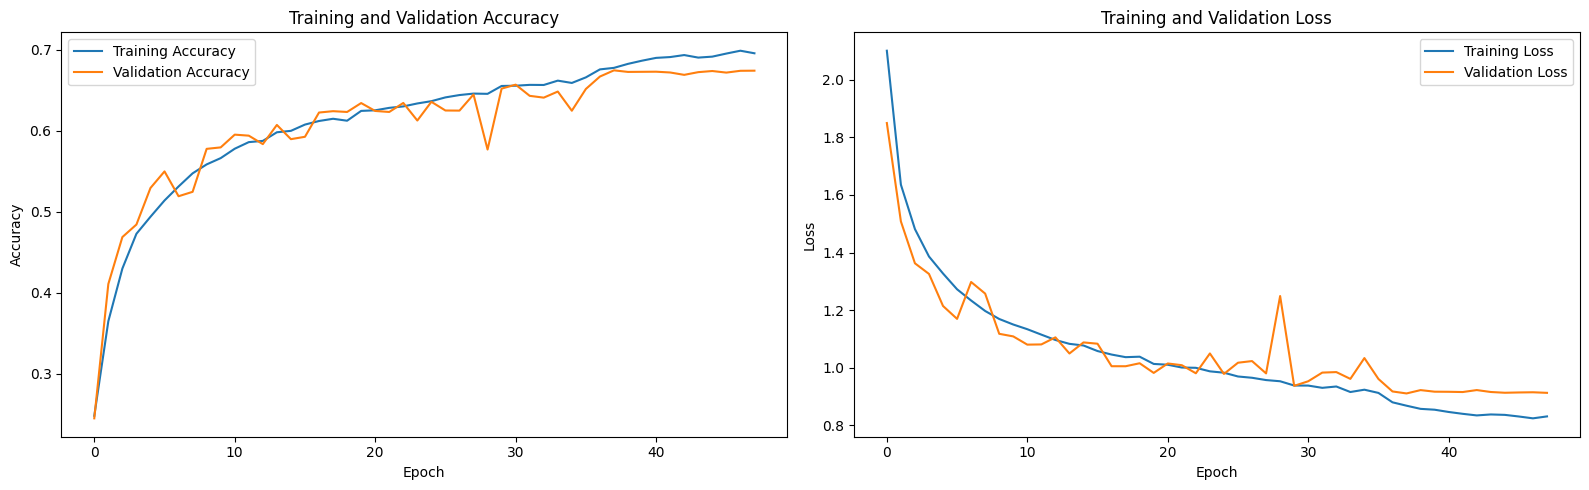

In [140]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft_df["accuracy"], label="Training Accuracy")
plt.plot(history_ft_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_ft_df["loss"], label="Training Loss")
plt.plot(history_ft_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

In [143]:
model_ft.trainable = False
# model_ft.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_fine_tune.h5") #google colab
model_ft.save('./model/model_fine_tune.h5') #local

### Model Evaluation

In [144]:
model_ft.evaluate(test_ds)
preds_ft = model_ft.predict(test_ds)
y_preds_ft = np.argmax(preds_ft , axis = 1 )
y_test_ft = np.array(test_ds.labels)

113/113 [==============================] - 3s 23ms/step


In [145]:
cm_array_ft = confusion_matrix(y_true=y_test_ft, y_pred=y_preds_ft)

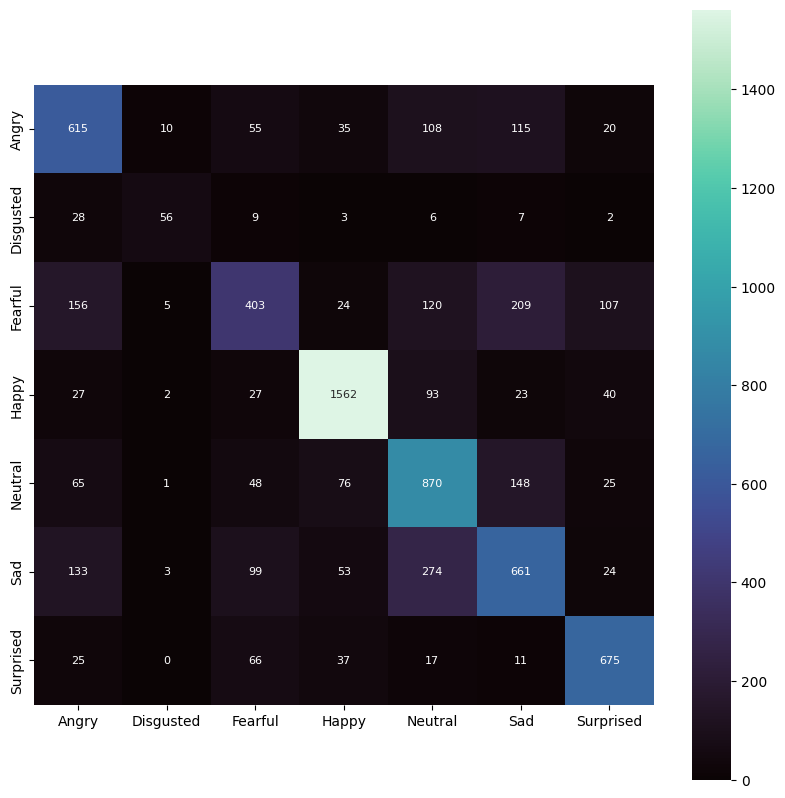

In [146]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array_ft, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)


In [147]:
print(classification_report(y_true=y_test_ft, y_pred=y_preds_ft))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61       958
           1       0.73      0.50      0.60       111
           2       0.57      0.39      0.47      1024
           3       0.87      0.88      0.88      1774
           4       0.58      0.71      0.64      1233
           5       0.56      0.53      0.55      1247
           6       0.76      0.81      0.78       831

    accuracy                           0.67      7178
   macro avg       0.67      0.64      0.65      7178
weighted avg       0.67      0.67      0.67      7178



## 05 - Prediction Analysis

In [148]:
# Get the file paths and corresponding labels from test_ds
file_paths = test_ds.filepaths
labels = test_ds.classes

# Create a DataFrame
data = {'file_path': file_paths, 'label': labels}
data_true = pd.DataFrame(data)

emotion_true=[]
for i,x in data_true.iterrows():
    if x['label'] == 0:
        value = 'Angry'
    elif x['label'] == 1:
        value = 'Disgusted'
    elif x['label'] == 2:
        value = 'Fearful'
    elif x['label'] == 3:
        value = 'Happy'
    elif x['label'] == 4:
        value = 'Neutral'
    elif x['label'] == 5:
        value = 'Sad'
    elif x['label'] == 6:
        value = 'Surprised'
    else:
        value = 'Unknown'
    emotion_true.append(value)

data_true['label']=emotion_true

In [149]:
prediction = pd.DataFrame(y_preds_ft, columns=['prediction'])

In [150]:
emotion = []
for i,x in prediction.iterrows():
    if x[0] == 0:
        value = 'Angry'
    elif x[0] == 1:
        value = 'Disgusted'
    elif x[0] == 2:
        value = 'Fearful'
    elif x[0] == 3:
        value = 'Happy'
    elif x[0] == 4:
        value = 'Neutral'
    elif x[0] == 5:
        value = 'Sad'
    elif x[0] == 6:
        value = 'Surprised'
    else:
        value = 'Unknown'
    emotion.append(value)

In [151]:
prediction['emotion'] = emotion
prediction['path'] = data_true['file_path']
prediction['true emotion'] = data_true['label']

In [152]:
def compare_pred(label, prediction):
    fig, axs = plt.subplots(2, 7, figsize=(21, 5))
    
    count = 0
    for i, x in prediction.iterrows():
        if count < 7:
            image = plt.imread(x['path'])
            if x['true emotion'] == label and x['emotion'] == label:
                axs[0, count].set_title(f"Pred: {x['emotion']}, True: {x['true emotion']}")
                axs[0, count].imshow(image, cmap="gray")
                count += 1
        elif count < 14:
            image = plt.imread(x['path'])
            if x['true emotion'] == label and x['emotion'] != label:
                axs[1, count-7].set_title(f"Pred: {x['emotion']}, True: {x['true emotion']}")
                axs[1, count-7].imshow(image, cmap="gray")
                count += 1
    
    fig.axes[0].set_ylabel("Positive Prediction")
    fig.axes[7].set_ylabel("Negative Prediction")
    fig.tight_layout()

### Angry Prediction

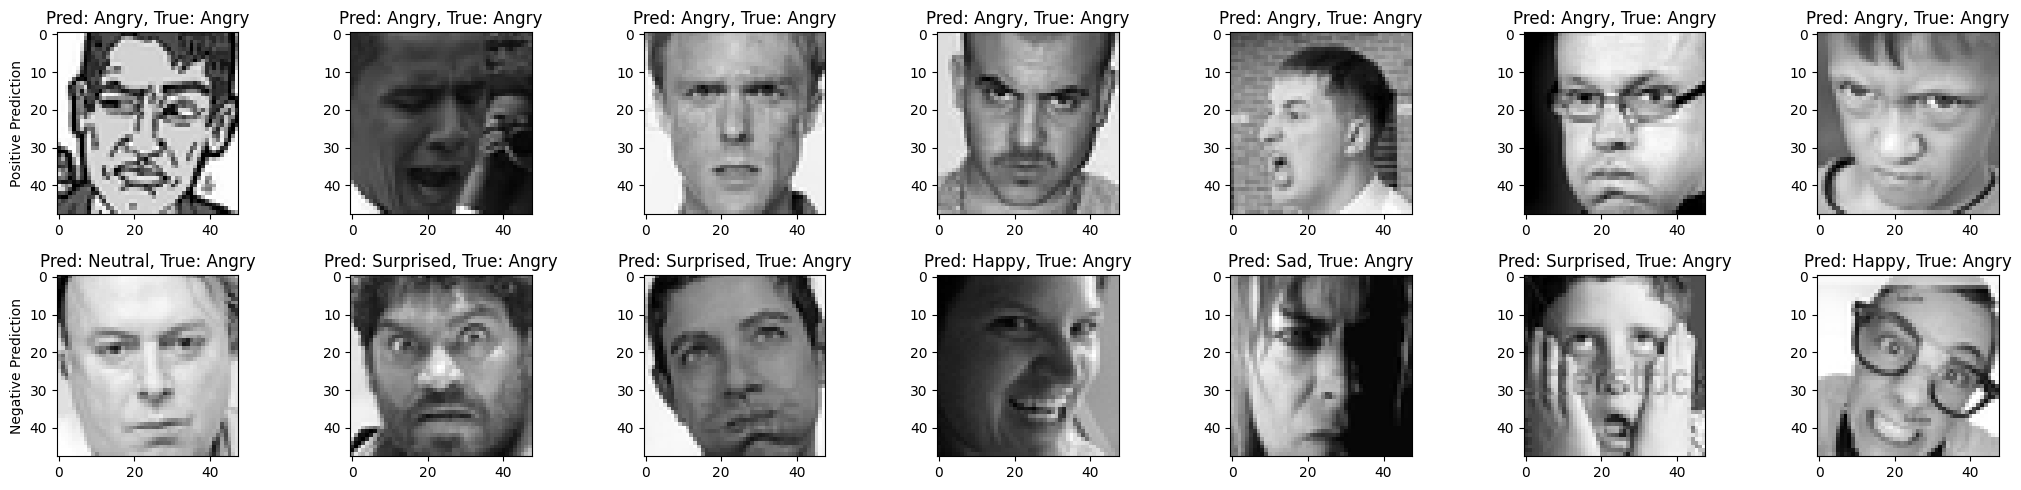

In [153]:
compare_pred('Angry', prediction)

### Disgusted Prediction

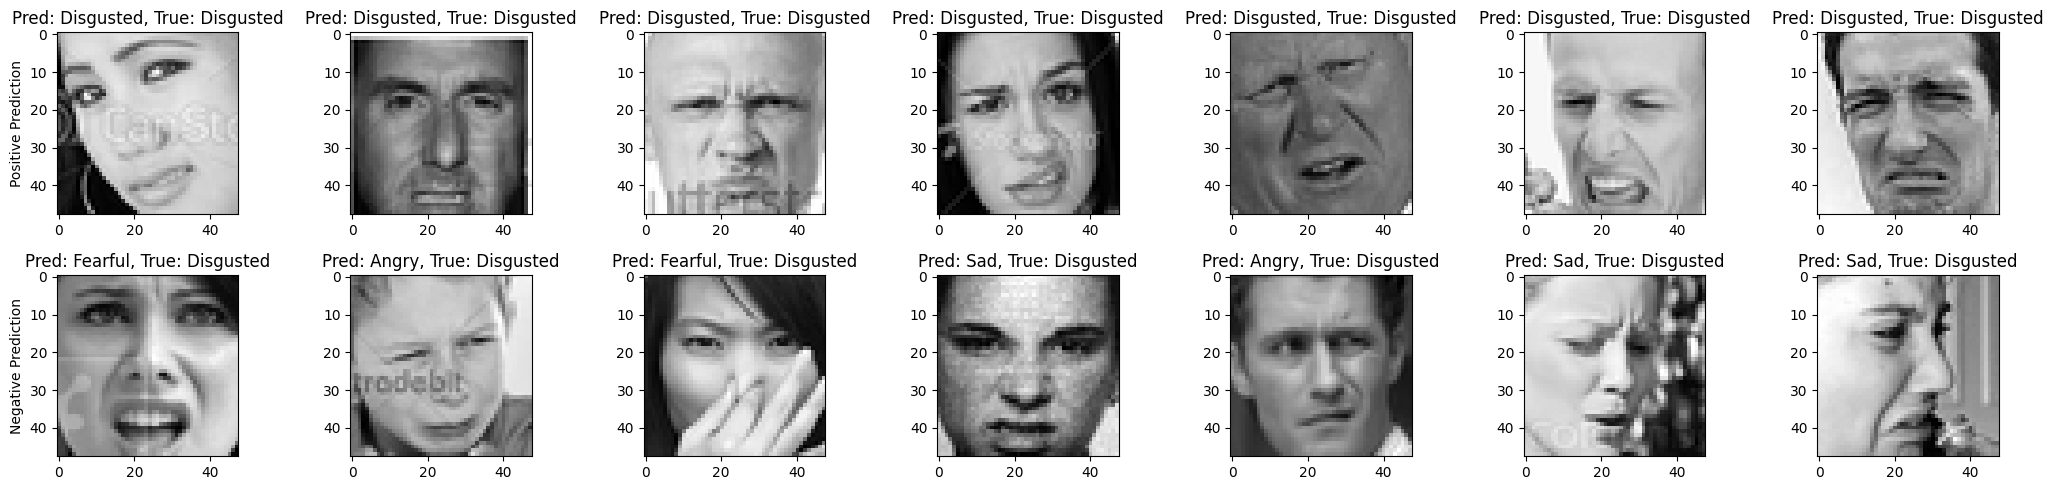

In [154]:
compare_pred('Disgusted', prediction)

### Fearful Prediction

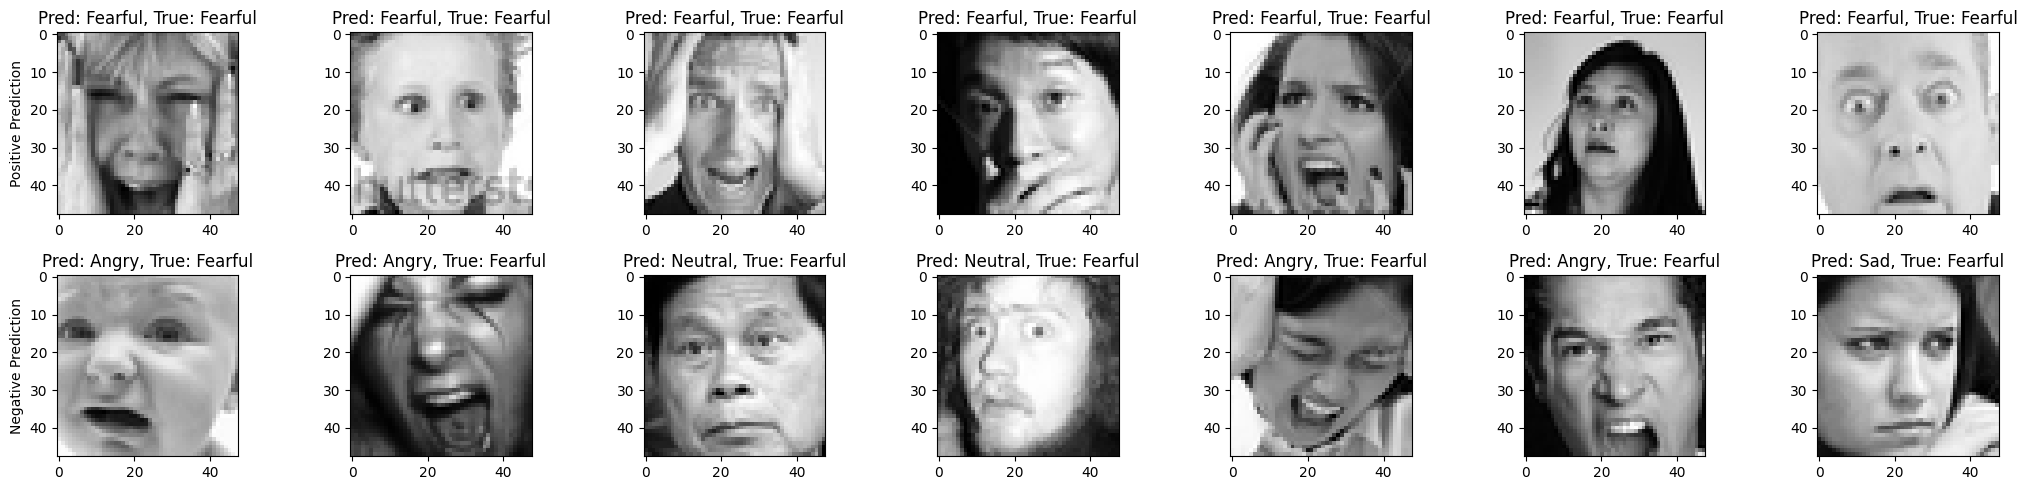

In [155]:
compare_pred('Fearful', prediction)

### Happy Prediction

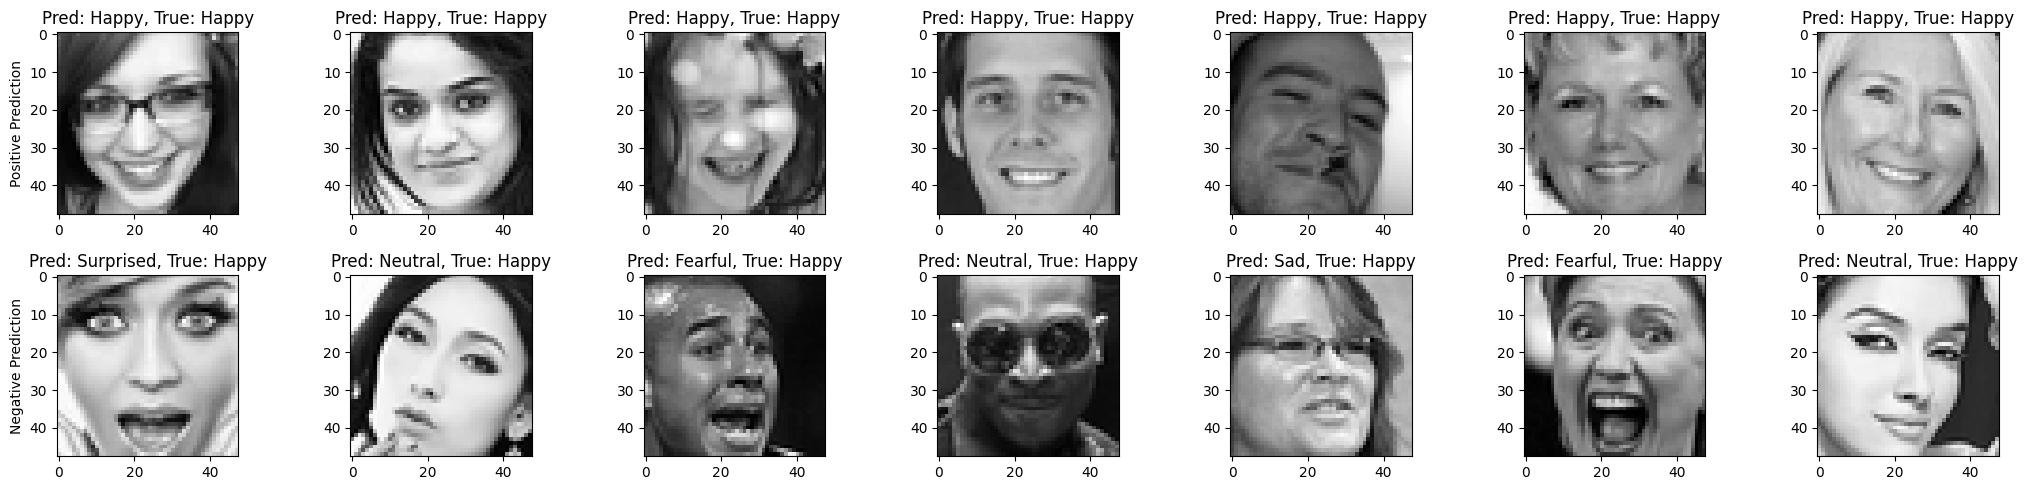

In [156]:
compare_pred('Happy', prediction)

### Neutral Prediction

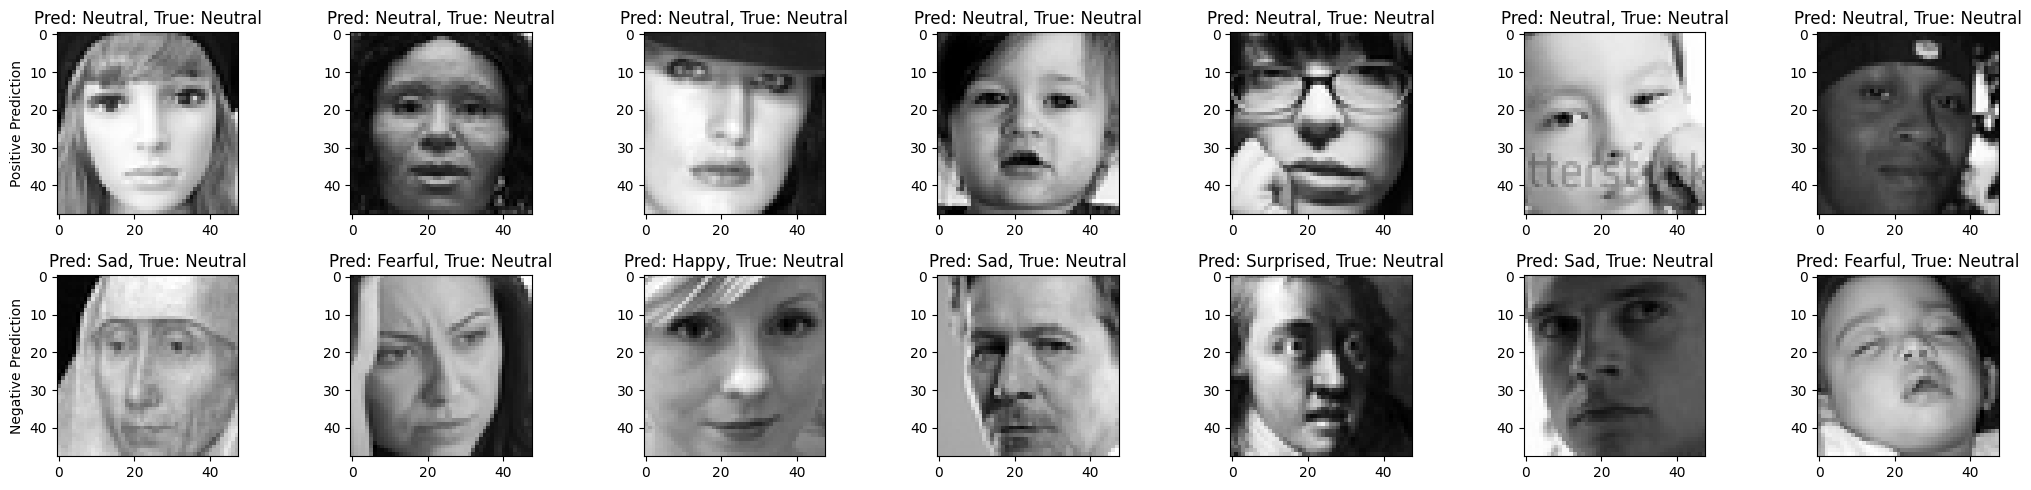

In [157]:
compare_pred('Neutral', prediction)

### Sad Prediction

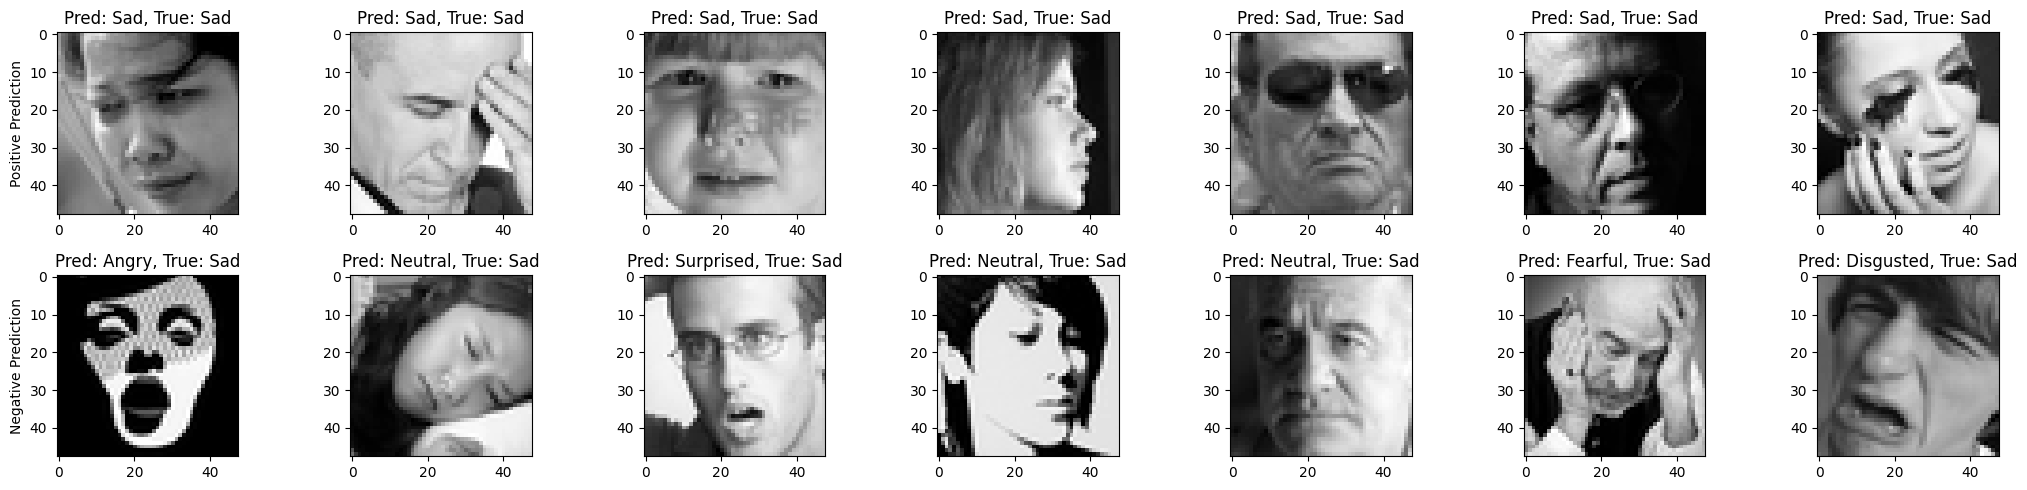

In [158]:
compare_pred('Sad', prediction)

### Suprised Prediction

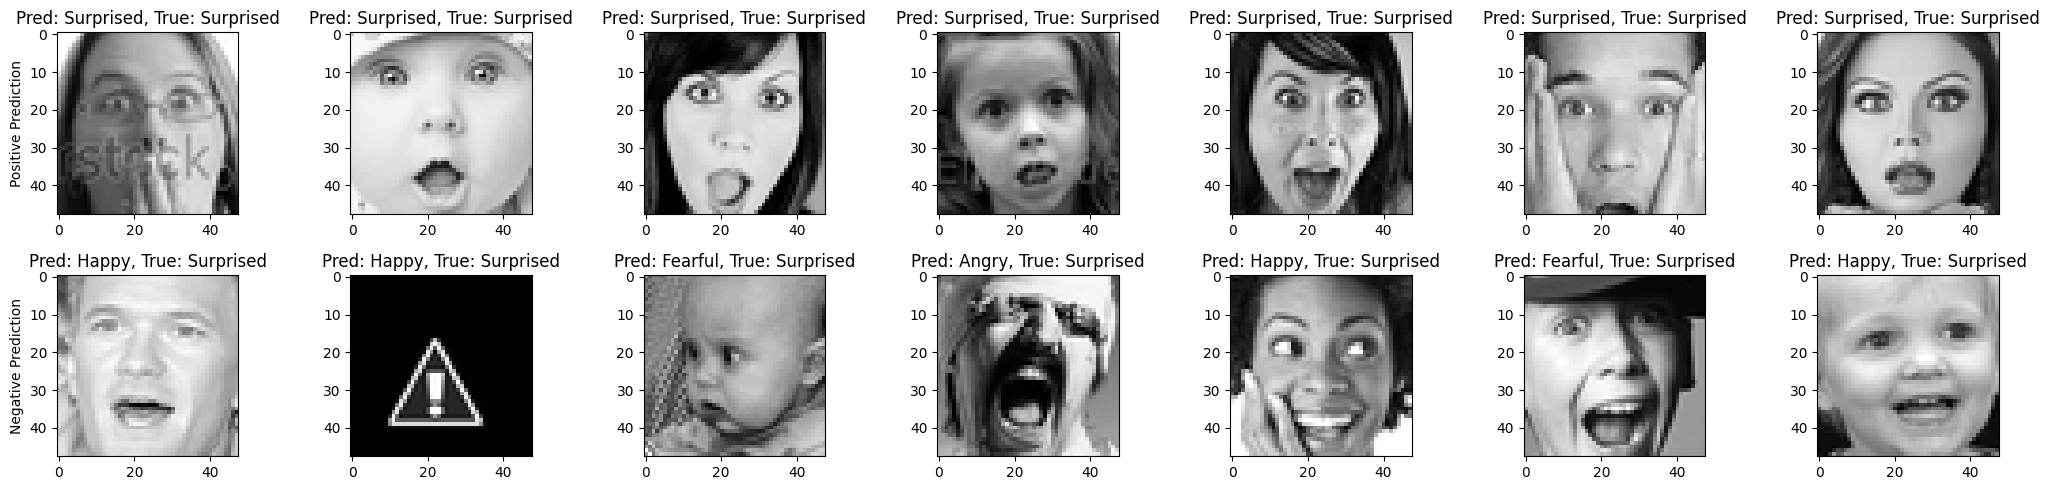

In [159]:
compare_pred('Surprised', prediction)

## 07 - Inferencing

In [252]:
emotion_classification_model = load_model('./model/model_fine_tune.h5')

In [280]:
inf_path = './inferencing/image/'
image_inf = os.listdir(inf_path)
image_inf

['momo (1).jpg',
 'momo (2).jpg',
 'momo (4).jpg',
 'momo (5).jpg',
 'QMyWMTvH_400x400.jpg']

In [281]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_fun)
inf_ds = train_datagen.flow_from_directory(directory = './inferencing/',
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

inf_pred = emotion_classification_model.predict(inf_ds)

Found 5 images belonging to 1 classes.
1/1 [==============================] - 0s 46ms/step


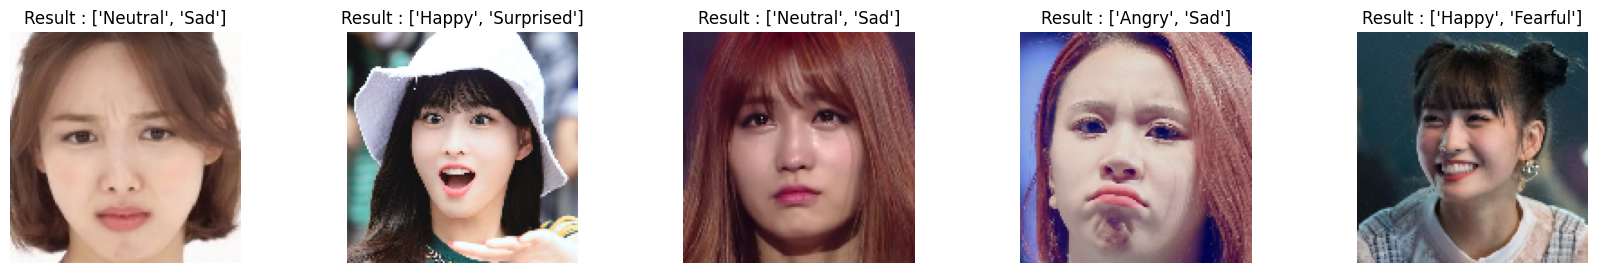

In [295]:
fig, axs = plt.subplots(1,5, figsize=(21,3))
prediction_result = pd.DataFrame(columns=["image", "prediction", "angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"])

for x,i in enumerate(inf_ds.filepaths):
    img =image.load_img(i, target_size=(128,128), keep_aspect_ratio=True)
    axs[x].imshow(img)
    axs[x].axis('off')
    max_pred = np.argsort(inf_pred[x])[-2:][::-1]
    pred_class = pd.DataFrame(class_labels).loc[max_pred][0].tolist()
    axs[x].set_title(f'Result : {pred_class}')
    
    data_inf = [i, pred_class]
    for i in inf_pred[x]:
        value = i *100
        data_inf.append(f'{value.round(2)}%')
        
    prediction_result.loc[len(prediction_result.index)] = data_inf
    

In [296]:
prediction_result

,image,prediction,angry,disgusted,fearful,happy,neutral,sad,surprised
0,./inferencing/image\QMyWMTvH_400x400.jpg,"[Neutral, Sad]",6.16%,0.17%,7.71%,1.08%,66.05%,18.79%,0.04%
1,./inferencing/image\momo (1).jpg,"[Happy, Surprised]",4.07%,0.02%,6.96%,60.95%,8.88%,6.96%,12.16%
2,./inferencing/image\momo (2).jpg,"[Neutral, Sad]",5.05%,0.01%,4.54%,0.09%,56.28%,33.92%,0.11%
3,./inferencing/image\momo (4).jpg,"[Angry, Sad]",45.09%,1.64%,4.93%,0.43%,15.2%,32.58%,0.14%
4,./inferencing/image\momo (5).jpg,"[Happy, Fearful]",1.75%,0.0%,17.8%,60.03%,2.87%,7.5%,10.04%
